## 0. EDA och filhantering

#### b) Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.

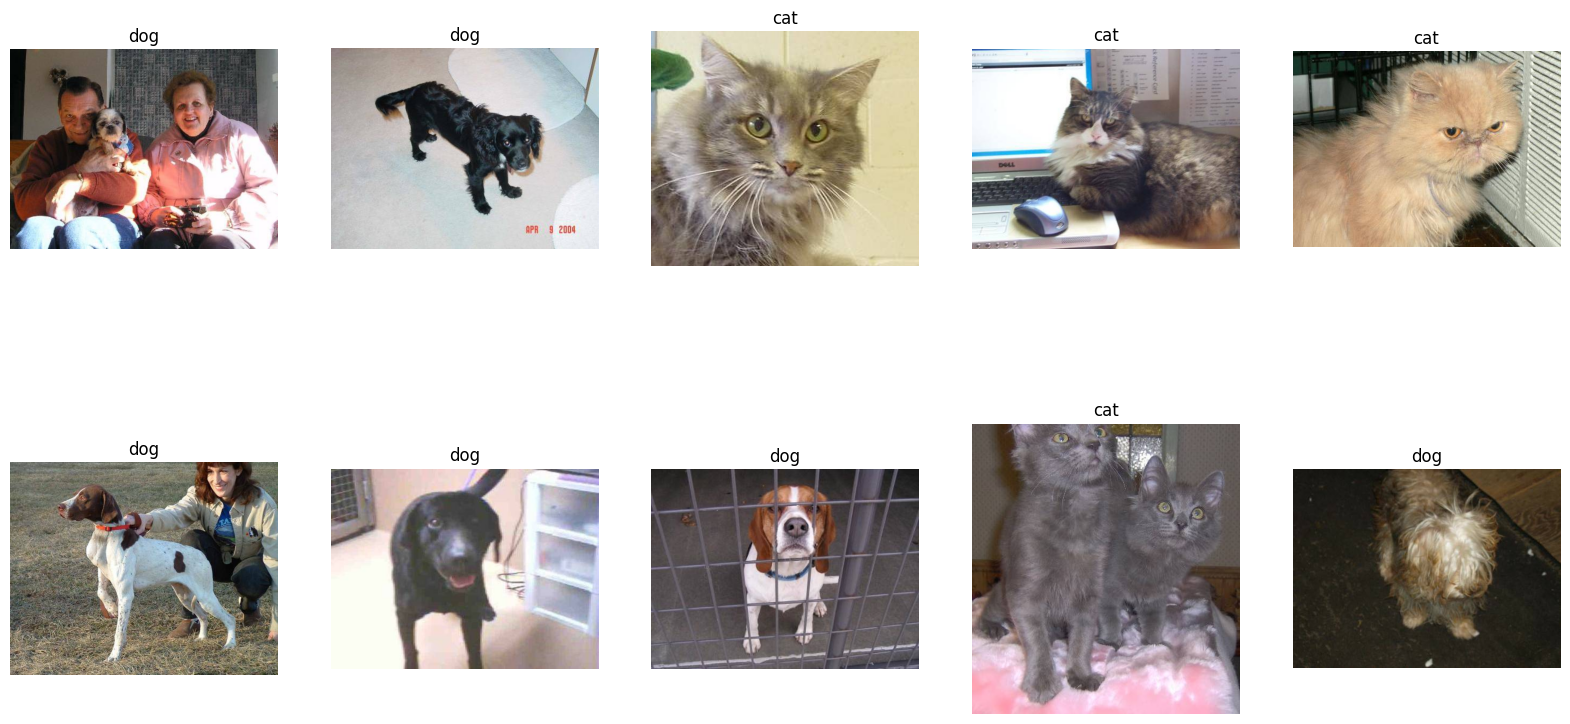

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from pathlib import Path

# Ange sökväg till din data
data_path = Path("original_data/train/train/")

# Hämta alla bildsökvägar
all_images = list(data_path.glob("*.jpg"))

# Välj 10 slumpmässiga bilder
selected_images = np.random.choice(all_images, 10, replace=False)

# Plotta bilder och deras labels
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = "dog" if "dog" in image_path.stem else "cat"
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()





In [31]:
import os
# skapar folders
folders = [
    'experiment_small_data/test/cats/dogs', 'experiment_small_data/train/cats/dogs', 'experiment_small_data/val/cats/dogs',
    'original_data/test/test', 'original_data/train/train'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)



### train|val|test split

In [32]:
import shutil

# Funktion för att dela upp och kopiera bilder
def distribute_images(source_folder, target_folder, num_train, num_val, num_test):
    dogs = list(source_folder.glob("*dog*.jpg"))
    cats = list(source_folder.glob("*cat*.jpg"))
    np.random.shuffle(dogs)
    np.random.shuffle(cats)

    # Definierar splits
    train_dogs, val_dogs, test_dogs = dogs[:800], dogs[800:1000], dogs[1000:1250]
    train_cats, val_cats, test_cats = cats[:800], cats[800:1000], cats[1000:1250]

    # Funktion för att kopiera filer
    def copy_files(files, path):
        for file in files:
            shutil.copy(file, path)

    # Skapa nya mappar om de inte redan finns
    os.makedirs(target_folder / 'train/dogs', exist_ok=True)
    os.makedirs(target_folder / 'val/dogs', exist_ok=True)
    os.makedirs(target_folder / 'test/dogs', exist_ok=True)
    os.makedirs(target_folder / 'train/cats', exist_ok=True)
    os.makedirs(target_folder / 'val/cats', exist_ok=True)
    os.makedirs(target_folder / 'test/cats', exist_ok=True)

    # Kopiera filer
    copy_files(train_dogs, target_folder / 'train/dogs')
    copy_files(val_dogs, target_folder / 'val/dogs')
    copy_files(test_dogs, target_folder / 'test/dogs')
    copy_files(train_cats, target_folder / 'train/cats')
    copy_files(val_cats, target_folder / 'val/cats')
    copy_files(test_cats, target_folder / 'test/cats')

# Ange käll- och målmappar
source_folder = Path("original_data/train/train")
target_folder = Path("experiment_small_data")

# Distribuera bilder
distribute_images(source_folder, target_folder, 1600, 400, 500)








#### e) Läs in dataseten från experiment_small och plocka ut labelsvektorer, som
#### ska vara one-hot encoded med 0 och 1.

In [33]:
from tensorflow.keras.utils import to_categorical

def load_data(directory):
    # Definiera basväg för datamappen
    base_path = Path(directory)
    # Definiera kategorier för klassificering
    categories = ['dogs', 'cats']
    # Initiera listor för att lagra bilder och deras respektive labels
    images = []
    labels = []
    # Loopa genom varje kategori
    for category in categories:
        # Skapa sökvägen för den aktuella kategorin
        category_path = base_path / category
        # Definiera klassnummer för den aktuella kategorin
        class_num = categories.index(category)
        # Loopa genom alla bilder i den aktuella kategorin
        for img_path in category_path.iterdir():
            try:
                # Läs in bilden från sökvägen
                img_array = cv2.imread(str(img_path))
                # Kontrollera om bilden har lästs in korrekt och inte är tom
                if img_array is not None and not img_array.size == 0:
                    # Ändra storlek på bilden till (224, 224)
                    img_array = cv2.resize(img_array, (224, 224))
                    # Lägg till bilden i listan med bilder
                    images.append(img_array)
                    # Lägg till klassnumret i listan med labels
                    labels.append(class_num)
            except Exception as e:
                # Hantera eventuella fel som kan uppstå vid inläsning av bilder
                print(f"Error processing image: {img_path}")
                print(e)
    # Konvertera listorna till numpy-arrayer för bilder och labels
    images = np.array(images)
    labels = to_categorical(labels, num_classes=2)  # One-hot encoding för labels
    return images, labels

# Uppdatera sökvägarna till att använda pathlib objekt och korrekt hantering
train_images, train_labels = load_data(Path('experiment_small_data/train'))
val_images, val_labels = load_data(Path('experiment_small_data/val'))
test_images, test_labels = load_data(Path('experiment_small_data/test'))



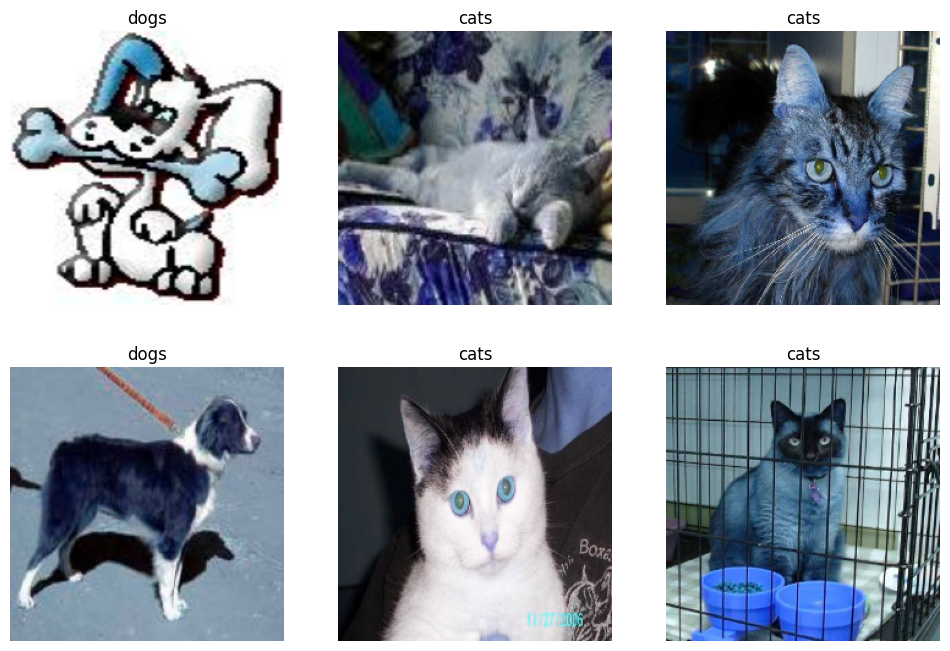

In [58]:

def plot_random_images_with_labels(images, labels, categories, num_images=6):
    # Skapa en ny figur för plottning
    plt.figure(figsize=(12, 8))
    # Välj slumpmässiga index från bildlistan
    random_indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(2, 3, i+1)
        # Plotta bilden med det slumpmässiga indexet
        plt.imshow(images[idx])
        # Hämta label för den aktuella bilden och sätt titeln på subploten
        plt.title(categories[np.argmax(labels[idx])])
        plt.axis('off')
    plt.show()

# Anropa funktionen med testdata och kategorier för att plotta slumpmässiga bilder
plot_random_images_with_labels(test_images, test_labels, categories)



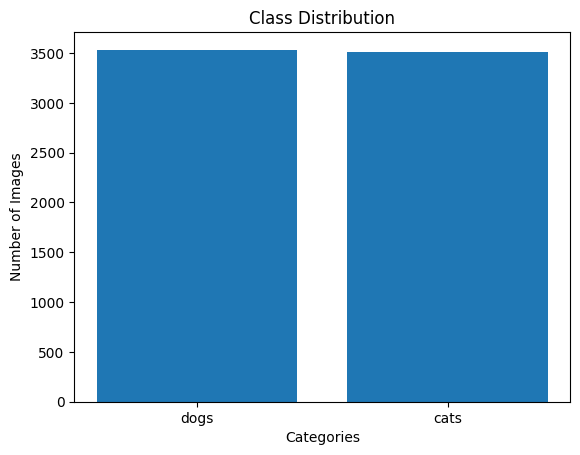

In [54]:
# Skapa en lämplig plot för att kontrollera att dataseten är balanserade
def plot_class_distribution(labels, categories):
    class_counts = np.sum(labels, axis=0)
    plt.bar(categories, class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.show()

# Plotta klassfördelning för experiment_small
plot_class_distribution(train_labels, categories)

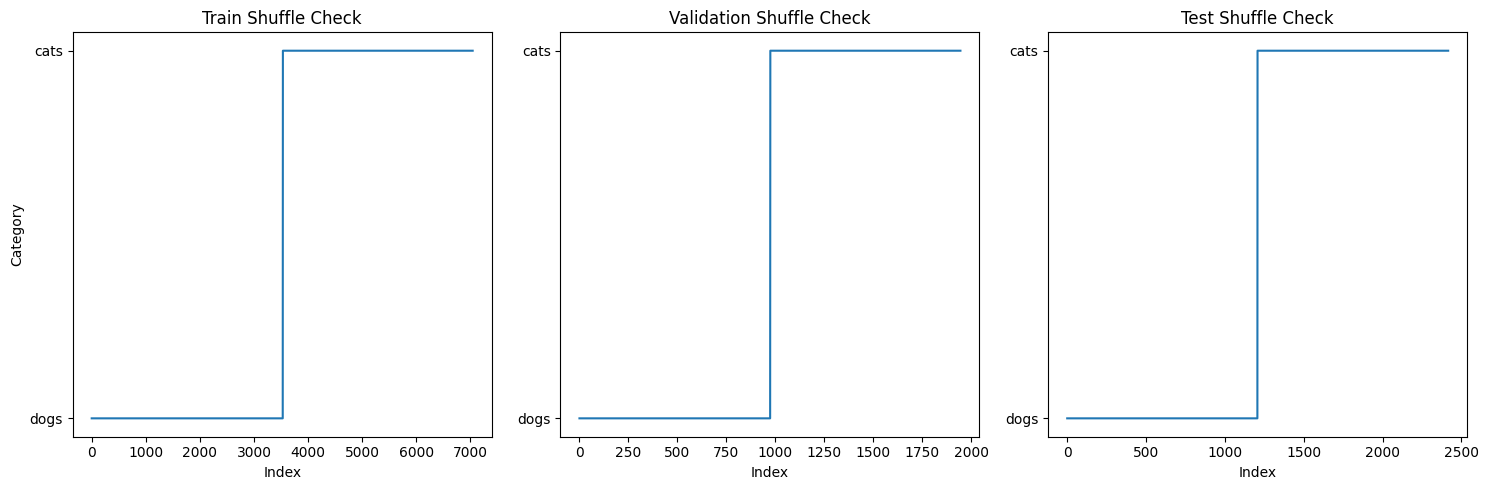

In [55]:
def plot_shuffle_check(train_labels, val_labels, test_labels, categories):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Train shuffle check
    train_indices = [np.argmax(label) for label in train_labels]
    axes[0].plot(train_indices)
    axes[0].set_title('Train Shuffle Check')
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel('Category')
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels(categories)

    # Validation shuffle check
    val_indices = [np.argmax(label) for label in val_labels]
    axes[1].plot(val_indices)
    axes[1].set_title('Validation Shuffle Check')
    axes[1].set_xlabel('Index')
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(categories)

    # Test shuffle check
    test_indices = [np.argmax(label) for label in test_labels]
    axes[2].plot(test_indices)
    axes[2].set_title('Test Shuffle Check')
    axes[2].set_xlabel('Index')
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels(categories)

    plt.tight_layout()
    plt.show()

# Plotta shuffle check för train, val och test för experiment_small
plot_shuffle_check(train_labels, val_labels, test_labels, categories)


## Bildbehandling

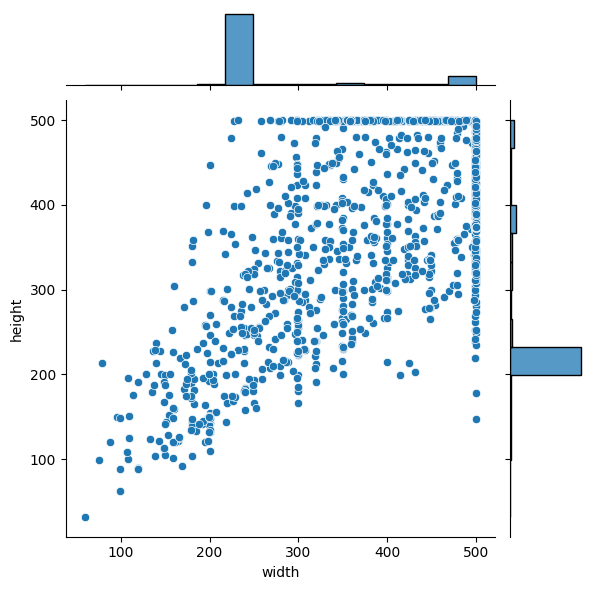

In [37]:
# sökväg till träningsdata
train_dogs_path = Path("experiment_small_data/train/dogs")
train_cats_path = Path("experiment_small_data/train/cats")

# Samlar alla bildsökvägar
train_images = list(train_dogs_path.glob("*.jpg")) + list(train_cats_path.glob("*.jpg"))

# Samlar bildstorlekar
sizes = [(cv2.imread(str(image)).shape[0], cv2.imread(str(image)).shape[1]) for image in train_images]

# Skapa en DataFrame för att enklare hantera data
import pandas as pd
df_sizes = pd.DataFrame(sizes, columns=["height", "width"])

# Plotta relationen mellan höjd och bredd på bilderna
sns.jointplot(data=df_sizes, x="width", y="height", kind="scatter")
plt.show()


#### 1b Välj en lämplig bildstorlek

In [38]:
# För att ändra storlek på bilderna
def resize_images(image_paths, size=(224, 224)):
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        img_resized = cv2.resize(img, size)
        cv2.imwrite(str(image_path), img_resized)

resize_images(train_images)  # Uppdatera alla träningsbilder till den nya storleken


#### 1c Spara bilder i numpy arrays

In [39]:
# Ladda om bilderna och spara dem som en numpy array
def load_images_to_array(image_paths, size=(224, 224)):
    # Skapa en tom numpy array för att lagra bilderna
    images = np.zeros((len(image_paths), size[0], size[1], 3), dtype=np.uint8)
    # Loopa igenom varje bildsökväg och dess index
    for idx, image_path in enumerate(image_paths):
        # Läs in bilden från filsystemet
        img = cv2.imread(str(image_path))
        # Ändra storleken på bilden till önskad storlek
        images[idx] = cv2.resize(img, size)
    return images

# Anropa funktionen för att ladda bilderna och spara dem som en numpy array
train_images_array = load_images_to_array(train_images)
# Skriv ut formen på den resulterande numpy arrayen
print(train_images_array.shape)



(7045, 224, 224, 3)


#### 1d Augmentera datan

Dataaugmentering är viktigt för att öka modellens generaliserbarhet och förhindra överanpassning, särskilt när vi har en begränsad mängd data. Augmentering kan inkludera rotationer, skalning, horisontell flipping, och färgvariationer.

Parametrarna för dataaugmentering väljs med hänsyn till typen av data, det specifika problemet som ska lösas och mängden tillgänglig data. Genom att överväga naturen av datan, typen av problem, tillgänglig mängd data och önskad inverkan kan man välja lämpliga parametrar. Det innebär att man kan experimentera med olika parametrar och utvärdera resultatet för att finjustera dataaugmenteringen för att uppnå bästa möjliga prestanda.

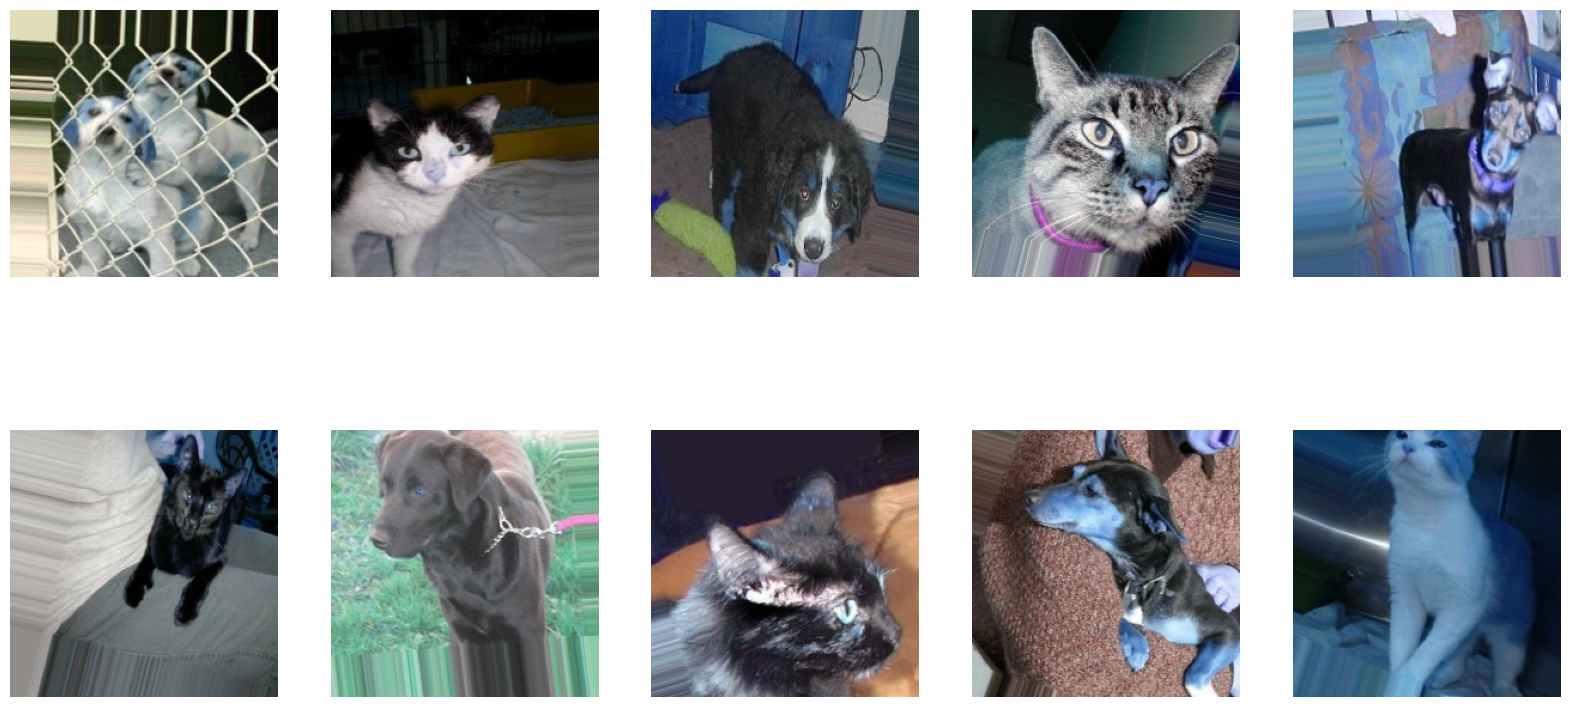

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definiera en ImageDataGenerator för dataaugmentering
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualisera några augmenterade bilder
augmented_images = next(data_gen.flow(train_images_array, batch_size=10))

plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i].astype('uint8'))
    plt.axis('off')
plt.show()
